### Compare theoretical and ground state energy at unit filling

In [59]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import pimc # custom module
from scipy.stats import truncexpon
from scipy.integrate import quad, simps
import importlib
importlib.reload(pimc)

<module 'pimc' from '/Users/ecasiano/Desktop/LatticePIMC/src/pimc.py'>

### Simulation parameters

In [60]:
importlib.reload(pimc)
# Simulation parameters
t = 1
mu = 0
U = 1
L = 4
N = 4
    
# PIMC parameters
beta = 1
eta = 1      # worm end fugacity
eta = 1/np.sqrt(L*beta)

# Canonical or Grand Canonical?
canonical = False # False means Grand Canonical

# Create a random worldline configuration
alpha = pimc.random_boson_config(L,N)
alpha = [1]*L
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []
#pimc.view_worldlines(data_struct,beta,figure_name=None)

### Do many iterations of the set of PIMC-WA updates

In [61]:
%%time
importlib.reload(pimc)

# Create the data structure
data_struct = pimc.create_data_struct(alpha)
head_loc = []
tail_loc = []

# Store values of observables
egs_list = []
n_list = []
occ_list = []

# Set the number of times the set of updates will be attempted
mc_steps = int(2E+05)

# Counters for acceptance of each move
insert_worm_data = [0,0] # [accepted,proposed]
delete_worm_data = [0,0]

insert_anti_data = [0,0]
delete_anti_data = [0,0]

acc_timeshift = 0
prop_timeshift = 0

insertZero_worm_data = [0,0]
deleteZero_worm_data = [0,0]

insertZero_anti_data = [0,0]
deleteZero_anti_data = [0,0]

insertBeta_worm_data = [0,0]
deleteBeta_worm_data = [0,0]

insertBeta_anti_data = [0,0]
deleteBeta_anti_data = [0,0]

ikbh_data = [0,0]
dkbh_data = [0,0]

ikah_data = [0,0]
dkah_data = [0,0]

ikbt_data = [0,0]
dkbt_data = [0,0]

ikat_data = [0,0]
dkat_data = [0,0]

# Count the times the configurations has no worm ends
Z_ctr = 0
for m in range(mc_steps):
    
    # Propose all moves sequentially
    result = pimc.worm_insert(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,insert_worm_data,insert_anti_data)

    result = pimc.worm_delete(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,delete_worm_data,delete_anti_data)
    
    result = pimc.worm_timeshift(data_struct,beta,head_loc,tail_loc,U,mu,canonical,N)
    if result != None:
        prop_timeshift += 1
        acc_timeshift += result
        
    result = pimc.insertZero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,insertZero_worm_data,insertZero_anti_data)
        
    result = pimc.deleteZero(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,deleteZero_worm_data,deleteZero_anti_data)
        
    result = pimc.insertBeta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,insertBeta_worm_data,insertBeta_anti_data)
        
    result = pimc.deleteBeta(data_struct,beta,head_loc,tail_loc,U,mu,eta,canonical,N,deleteBeta_worm_data,deleteBeta_anti_data)
    
    result = pimc.insert_kink_before_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,canonical,N,ikbh_data)  
        
    result = pimc.delete_kink_before_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,canonical,N,dkbh_data) 
        
    result = pimc.insert_kink_after_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,canonical,N,ikah_data)   
        
    result = pimc.delete_kink_after_head(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,canonical,N,dkah_data)
    
    result = pimc.insert_kink_before_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,canonical,N,ikbt_data)  
        
    result = pimc.delete_kink_before_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,canonical,N,dkbt_data) 
    
    result = pimc.insert_kink_after_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,canonical,N,ikat_data)   
        
    result = pimc.delete_kink_after_tail(data_struct,beta,head_loc,tail_loc,t,U,mu,eta,canonical,N,dkat_data)
        
    # Calculate observables when there are no worms present
    if m >= 0.01*mc_steps and m%L==0: # Ignore unequilibrated data
        if not(pimc.check_worm(head_loc,tail_loc)):
            egs_list.append(pimc.egs_pimc(data_struct,beta,U,mu)) # <E>
            n_list.append(pimc.n_pimc(data_struct,beta)/L) # <n>
            occ_list.append(pimc.n_i_pimc(data_struct,beta))
            Z_ctr += 1

CPU times: user 22.2 s, sys: 130 ms, total: 22.4 s
Wall time: 22.3 s


N_check:  1.260686744050861


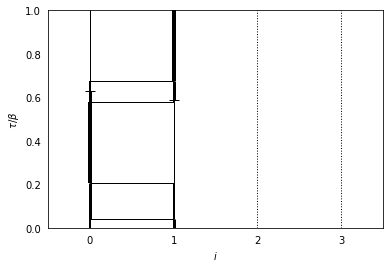

In [62]:
print("N_check: ",pimc.N_tracker(data_struct,beta)/L)
pimc.view_worldlines(data_struct,beta,figure_name=None)

In [63]:
head_loc,tail_loc

([0, 4], [1, 4])

In [64]:
# Acceptance ratios
print("-------- Acceptance Ratios --------\n")

print("       Insert worm: %.4f%% (%d/%d)"%(100*insert_worm_data[0]/insert_worm_data[1],insert_worm_data[0],insert_worm_data[1]))
print("       Delete worm: %.4f%% (%d/%d)\n"%(100*delete_worm_data[0]/delete_worm_data[1],delete_worm_data[0],delete_worm_data[1]))

print("       Insert anti: %.4f%% (%d/%d)"%(100*insert_anti_data[0]/insert_anti_data[1],insert_anti_data[0],insert_anti_data[1]))
print("       Delete anti: %.4f%% (%d/%d)\n"%(100*delete_anti_data[0]/delete_anti_data[1],delete_anti_data[0],delete_anti_data[1]))

#print("         Timeshift: %.4f%% (%d)\n"%(100*acc_timeshift/prop_timeshift,prop_timeshift))

print("   InsertZero worm: %.4f%% (%d/%d)"%(100*insertZero_worm_data[0]/insertZero_worm_data[1],insertZero_worm_data[0],insertZero_worm_data[1]))
print("   DeleteZero worm: %.4f%% (%d/%d)\n"%(100*deleteZero_worm_data[0]/deleteZero_worm_data[1],deleteZero_worm_data[0],deleteZero_worm_data[1]))

print("   InsertZero anti: %.4f%% (%d/%d)"%(100*insertZero_anti_data[0]/insertZero_anti_data[1],insertZero_anti_data[0],insertZero_anti_data[1]))
print("   DeleteZero anti: %.4f%% (%d/%d)\n"%(100*deleteZero_anti_data[0]/deleteZero_anti_data[1],deleteZero_anti_data[0],deleteZero_anti_data[1]))

print("   InsertBeta worm: %.4f%% (%d/%d)"%(100*insertBeta_worm_data[0]/insertBeta_worm_data[1],insertBeta_worm_data[0],insertBeta_worm_data[1]))
print("   DeleteBeta worm: %.4f%% (%d/%d)\n"%(100*deleteBeta_worm_data[0]/deleteBeta_worm_data[1],deleteBeta_worm_data[0],deleteBeta_worm_data[1]))

print("   InsertBeta anti: %.4f%% (%d/%d)"%(100*insertBeta_anti_data[0]/insertBeta_anti_data[1],insertBeta_anti_data[0],insertBeta_anti_data[1]))
print("   DeleteBeta anti: %.4f%% (%d/%d)\n"%(100*deleteBeta_anti_data[0]/deleteBeta_anti_data[1],deleteBeta_anti_data[0],deleteBeta_anti_data[1]))

print("              IKBH: %.4f%% (%d/%d)"%(100*ikbh_data[0]/ikbh_data[1],ikbh_data[0],ikbh_data[1])) 
print("              DKBH: %.4f%% (%d/%d)\n"%(100*dkbh_data[0]/dkbh_data[1],dkbh_data[0],dkbh_data[1]))

print("              IKAH: %.4f%% (%d/%d)"%(100*ikah_data[0]/ikah_data[1],ikah_data[0],ikah_data[1])) 
print("              DKAH: %.4f%% (%d/%d)\n"%(100*dkah_data[0]/dkah_data[1],dkah_data[0],dkah_data[1])) 

print("              IKBT: %.4f%% (%d/%d)"%(100*ikbt_data[0]/ikbt_data[1],ikbt_data[0],ikbt_data[1])) 
print("              DKBT: %.4f%% (%d/%d)\n"%(100*dkbt_data[0]/dkbt_data[1],dkbt_data[0],dkbt_data[1]))

print("              IKAT: %.4f%% (%d/%d)"%(100*ikat_data[0]/ikat_data[1],ikat_data[0],ikat_data[1])) 
print("              DKAT: %.4f%% (%d/%d)\n"%(100*dkat_data[0]/dkat_data[1],dkat_data[0],dkat_data[1])) 

-------- Acceptance Ratios --------

       Insert worm: 63.7614% (3014/4727)
       Delete worm: 71.8822% (3441/4787)

       Insert anti: 42.1297% (1994/4733)
       Delete anti: 63.4680% (2090/3293)

   InsertZero worm: 53.4318% (12043/22539)
   DeleteZero worm: 62.7562% (11758/18736)

   InsertZero anti: 45.4703% (8121/17860)
   DeleteZero anti: 42.0914% (7837/18619)

   InsertBeta worm: 56.0534% (11422/20377)
   DeleteBeta worm: 43.0713% (8246/19145)

   InsertBeta anti: 42.7952% (8485/19827)
   DeleteBeta anti: 62.3752% (11182/17927)

              IKBH: 24.1352% (42077/174339)
              DKBH: 90.0866% (41938/46553)

              IKAH: 14.0800% (24547/174339)
              DKAH: 87.4026% (24679/28236)

              IKBT: 14.4158% (25419/176327)
              DKBT: 90.0776% (25546/28360)

              IKAT: 24.5317% (43256/176327)
              DKAT: 89.1839% (43132/48363)



N_check:  5.042746976203444


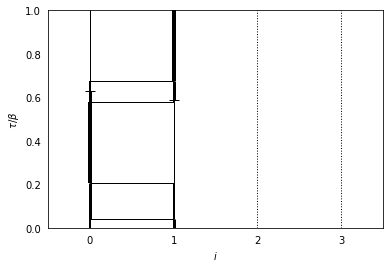

In [65]:
print("N_check: ",pimc.N_tracker(data_struct,beta))
pimc.view_worldlines(data_struct,beta,figure_name=None)

### Process data

In [66]:
egs = np.mean(egs_list)
n = np.mean(n_list)
occ = np.mean(occ_list,axis=0)
samples = len(egs_list)
print(samples)

2282


In [67]:
importlib.reload(pimc)
print("Samples: %d"%samples)
print("-------- Ground State Energy --------")
print("PIMC: %.8f"%egs)
#print("Exact: %.8f"%pimc.egs_theory(L,U,mu))
print("-------- Average particles per site --------")
print("PIMC: %.8f"%n)
print("-------- Average occupation --------")
print("PIMC:",occ)
print("-------- Z-configuration fraction --------")
print("Z-fraction: %.2f%%"%(Z_ctr/mc_steps*100))

Samples: 2282
-------- Ground State Energy --------
PIMC: 2.21472393
-------- Average particles per site --------
PIMC: 1.27979842
-------- Average occupation --------
PIMC: [1.30148992 1.29623138 1.25416301 1.26730938]
-------- Z-configuration fraction --------
Z-fraction: 1.14%


### Save data

In [ ]:
egs_list = np.array(egs_list)
with open("egs_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,egs_list,delimiter=",",fmt="%.16f",header="MC_step <E> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
n_list = np.array(n_list)
with open("n_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,n_list,delimiter=",",fmt="%.16f",header="MC_step <n> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))
    
occ_list = np.array(occ_list)
with open("occ_%i_%i_%.4f_%.4f_%.4f_%i.dat"%(L,N,U,mu,eta,mc_steps),"w+") as data:
    np.savetxt(data,occ_list,delimiter=",",fmt="%.16f",header="MC_step <n_i> // BH Parameters: L=%d,N=%d,U=%.8f,mu=%.8f,eta=%.8f,MC_steps=%i"%(L,N,U,mu,eta,mc_steps))    